# Exercise 1. Understanding offline and online imitation learning

In this problem, you will focus on imitation learning (IL) and get more insights for behavioral cloning (BC), data aggregation with DAgger, and policy aggregation via SMile. You will play with a classical robotic control task in [OpenAI Gym](https://gym.openai.com/), i.e., the [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment.


This problem focuses on a regime with a low data rate (small training set) so that it is straightforward to compare the efficiency of offline and online IL approaches. Efficiency here refers to i) the number of demonstrations needed from the expert; and ii) the number of updates to learn the policy. This assignment can run perfectly on a laptop.

**Randomness and reproducibility.**
We employ pseudo-randomness to ensure randomness and reproducibility at the same time, as was done in most of deep learning tasks. To this end, there are two lines of code that you will see a few times.

- `seed_everything(seed)`
- `env.reset(seed=seed)`

The first line resets the seed for packages such as `torch`, and `numpy`. This will be used to ensure that the neural network parameters are initialized the same (if necessary). The second is used to cope with the randomness for `CartPole` environment. More details will be provided on the latter.


###  Step 1. Set up environments

The first step is to get familiar with packages. We will work with libraries `torch`, `gym`, and `stable_baselines3`. Most people should be familiar with `torch` already, hence we put more emphasis on the other two packages.

- [`gym`](https://www.gymlibrary.dev/index.html) and [`gymnasium`](https://gymnasium.farama.org/) provide APIs for simulating a control problem (e.g., CartPole), a game (e.g., Atari), and other environments for RL.


- [`stable_baselines3`](https://stable-baselines3.readthedocs.io/en/master/) implements various RL algorithms. These algorithms can be easily applied on environments from `gym`. 


Typically, you can use `pip` or `conda` to install these packages. Just in case that there are problems with package versions, we have tested our code in the environment below `python 3.9.7`, `torch 2.2.2`, `gym 0.26.2`, `gymnasium 0.29.1`. It is recommended to install packages yourself, but if it does not work, you can run the command below for installing needed packages. 
```bash
conda env create -n forl -f enviroment.yml
conda activate forl
```



You will focus on the [**CarPole**](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) in this problem. In particular, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The goal is to keep the pole upright for as long as possible.
A graphical illustration can be found [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).

In the framework of RL, this problem can be defined by

- **State.** The observation is a ndarray with shape (4,) with the values corresponding to

| state    | meaning               | min            | max
| -------- | -------               | -----          | -----
| state(0) | cart position         | - 4.8          | 4.8
| state(1) | cart velocity         | - inf          | inf
| state(2) | pole angle            | -24$^\circ$    | 24$^\circ$ 
| state(3) | pole angular velocity | - inf          | inf


- **Action.** An action is a ndarray with shape (1,) which can take values {0, 1} to indicate the direction of the fixed force the cart is pushed with. 0 and 1 mean to push the cart to left and right, respectively.

- **Reward.** Since the goal is to keep the pole upright for as long as possible, a reward is +1 for every step taken, including the termination step.

- **Initialization.** A uniformly random value in (-0.05, 0.05)

- **Episode end.** The episode ends if any one of the following occurs: 1) pole angle is greater than $\pm 12^\circ$; 2) cart position is greater than $\pm 2.4$ (center of the cart reaches the edge of the display); or 3) episode length is greater than 500.

The last termination condition means that the largest reward to achieve is $500$.


<b style="color:red">Question 1 (5 pts).</b> Install necessary packages, such that the RL environment can be set up by running the code below.



In [1]:
import gym
import numpy as np
import scipy as sp
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.data.dataset import Dataset, random_split

env_name = "CartPole-v1"
env = gym.make(env_name)

### Step 2. Preparation

Once the environment is set up, you can prepare the expert needed for IL. You do not need to code anything until this point, although you can play with the hyperparameters for fun.


The expert is a multi-layer neural network trained by PPO. Training takes a few minutes (typically less than 5 min).
Running the code below, you can see that the reward is 500 after training. This means that your expert can solve the CartPole *perfectly*. 


In [2]:

def seed_everything(seed: int):
    """
    This is used for reproducing. Do not modify.
    """
    random.seed(seed)
    np.random.seed(seed)
#     sp.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    

seed_everything(12345)


# Initialize our expert
# Note: you can also set verbose=1 to see the training logs.
expert = PPO('MlpPolicy', env_name, learning_rate=2e-4, verbose=0, seed=111)

# Check the architecture of policy neural network
print('========= Policy Net =========')
print(expert.policy)
print('========= Policy Net =========')

# Evaluate your expert before training
env.reset(seed=10)
mean_reward, std_reward = evaluate_policy(expert, env, n_eval_episodes=10)
print(f'Before training, the reward of our expert is {mean_reward} +/- {std_reward}')

print('========= Training ==========')
expert.learn(total_timesteps=5e4) 

# Evaluate your expert after training
env.reset(seed=10)
mean_reward, std_reward = evaluate_policy(expert, env, n_eval_episodes=10)
print(f'After training, the reward of our expert is {mean_reward} +/- {std_reward}')


========= Policy Net =========
ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)
========= Policy Net =========
Before training, the reward of our expert is 9.3 +/- 0.7810249675906655


/Users/dcsteinhauser/anaconda3/envs/forl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/dcsteinhauser/anaconda3/envs/forl/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/Users/dcsteinhauser/anaconda3/envs/forl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, 

After training, the reward of our expert is 490.6 +/- 28.2


### Step 3. Offline IL with Behavioral Cloning (BC) <b style="color:red">(5 points) </b>

You will work with an offline IL algorithm -- BC. Read the code below, you will be asked to perform some analysis. There is no need to tune hyperparameters, but you can play with them for better understanding.

**When hand in this assignment, please use hyperparameters provided.**


**Note on randomness**. Our protocol is that we keep a seed in IL algorithms (e.g., BC). Each time after calling `env.reset(seed=seed)`, we increment seed by 1 to ensure randomness and reproducibility. 


In [3]:

class ExpertData(Dataset):
    """
    Dataset for expert demonstrations

    :param expert_observations: tensor of size [num_demonstrations, dim_state] 
    :param expert_actions: tensor of size [num_demonstrations, dim_action] 
    """
    
    def __init__(self, expert_observations, expert_actions):
        self.observations = expert_observations
        self.actions = expert_actions
        
    def __getitem__(self, index):
        return (self.observations[index], self.actions[index])
    
    def __len__(self):
        return len(self.observations)

    
class BehavioralCloning:
    def __init__(self, env, expert, student, args):
        """
        Main class for BC

        :param env: the CartPole environment
        :param expert: the expert to learn from (which is trained with PPO previously). In BC, it only provides demonstrations.
        :param student: the policy we hope to learn from expert demonstrations
        :param args: hyperparameters for training, you do not need to tune them. 
                     when hand in this assignment, please use the args provided.
        """
        
        self.env = env
        self.student = student
        self.expert = expert
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.seed = 0
        
        
    def expert_demonstration(self, num_data=200):
        """
        Prepare expert demonstrations
        
        :param num_data: number of demonstrations
        :return ExpertData: the dataset contains expert demonstrations
        """
        
        observations = np.empty((num_data,) + self.env.observation_space.shape)
        actions = np.empty((num_data,) + self.env.action_space.shape)
        
        obs, _ = self.env.reset(seed=self.seed)
        self.seed += 1

        for i in range(int(num_data)):
            action, _ = self.expert.predict(obs, deterministic=True)
            observations[i], actions[i] = obs, action
            obs, reward, done, _, _ = self.env.step(action)

            if done:
                obs, _ = self.env.reset(seed=self.seed)
                self.seed += 1
            
        return ExpertData(observations, actions)
        
        
    def train(self):
        """
        Using BC to learn a policy out of expert demonstrations
        """
        
        # prepare expert demonstrations
        demonstration = self.expert_demonstration(num_data=self.args['num_expert_demo'])
        demonstration = torch.utils.data.DataLoader(dataset=demonstration, batch_size=self.args['bs'], shuffle=True)
        
        # prepare student, optimizer
        model = self.student.policy.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.args['lr'])
        lr_scheduler = StepLR(optimizer, step_size=1, gamma=self.args['schedular_gamma'])
        
        criterion = nn.CrossEntropyLoss()
        
        model.train()
        for epoch in range(1, self.args['epochs'] + 1):
            for batch_idx, (data, target) in enumerate(demonstration):
                
                # get expert demonstration
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                
                # get student response
                dist = model.get_distribution(data)
                action_prediction = dist.distribution.logits
                target = target.long()
                
                # update student
                loss = criterion(action_prediction, target)
                loss.backward()
                optimizer.step()
                
            lr_scheduler.step()
                
        self.student.policy = model
    
    def evaluate(self):
        """
        evaluate a policy
        """
        self.env.reset(seed=self.seed)
        self.seed += 1
        self.student.policy.eval()
        mean_reward, std_reward = evaluate_policy(self.student, self.env, n_eval_episodes=10)
        return mean_reward, std_reward
        

# training arguments for BC
bc_args = dict(
    lr = 0.01,                  # learning rate
    bs = 2,                     # batch size
    schedular_gamma = 0.7,      # learning rate scheduler
    epochs = 5,                 # number of training epochs
    num_expert_demo = 400,      # number of expert demonstrations
)        

seed_everything(30)

# The student that learns from expert's demonstration 
# For this question, it will be a MLP trained with A2C
student = A2C('MlpPolicy', env_name, verbose=1)
bc = BehavioralCloning(env, expert, student, bc_args)

mean, std = bc.evaluate()
print('=' * 20)
print(f'Before applying BC, the reward of student is {mean} +/- {std}')

bc.train()
mean, std = bc.evaluate()
print('=' * 20)
print(f'After applying BC, the reward of student is {mean} +/- {std}')


Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before applying BC, the reward of student is 9.8 +/- 0.6
After applying BC, the reward of student is 267.6 +/- 154.07154182392023


**Training results.** In the small data regime, we train BC for 5 epochs to ensure sufficient convergence. The reward of BC should be around 450, which is clearly not optimal. Next you need to perform some analyses on the data efficiency.

<b style="color:red">Question 2 (5 pts).</b> In the code above, how many demonstrations are needed from experts? How many optimization steps are taken?


<span style="color:lightblue">400 expert demonstrations.
The total number of optimization steps is equal to </span> 
$$
\frac{\text{total number of demonstrations}}{\text{batch size}} \times \text{epochs}
$$ 
<span style="color:lightblue">Therefore we have a total number of 1000 optimization steps.</span>


### Step 3. IL with data aggregation  <b style="color:red">(20 points) </b>

Next, you will focus on DAgger, and compare its efficiency with BC. The DAgger can be summarized as

- Step 1. Train $\pi$ from expert's demonstrations ${\cal D}= \{ s_1, a_1, s_2, a_2, ...\}$

- Step 2. Run $\pi$ to get states $\hat{\cal D}_\pi = \{ s_1, s_2, .... \}$, and label these states using expert demonstrations ${\cal D}_\pi = \{ s_1, a_1, s_2, a_2 .... \}$

- Step 3. Aggregate ${\cal D} \leftarrow {\cal D} \cup {\cal D}_\pi$ and go to step 1

<b style="color:red">Question 3 (10 pts).</b> Implement and test DAgger by completing lines marked with **#TODO**. After the code is finished, it should get a final reward of 500. There is no need to tune hyperparameters. 

In [4]:
class DAgger:
    def __init__(self, env, expert, student, args):
        """
        Main class for DAgger. 

        :param env: the CartPole environment
        :param expert: the expert to learn from (which is trained with PPO previously).
        :param student: the policy we hope to learn from expert demonstrations
        :param args: hyperparameters for training, you do not need to tune them. 
                     when hand in this assignment, please use the args provided.
        """
        
        self.env = env
        self.student = student
        self.expert = expert
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.seed = 0
        
    def expert_demonstration(self, num_data=200):
        """
        Prepare expert demonstrations. 
        This is the same as BehavioralCloning.expert_demonstration()
        """
        observations = np.empty((num_data,) + self.env.observation_space.shape)
        actions = np.empty((num_data,) + self.env.action_space.shape)
        obs, _ = self.env.reset(seed=self.seed)
        self.seed += 1

        for i in range(int(num_data)):
            action, _ = self.expert.predict(obs, deterministic=True)
            observations[i], actions[i] = obs, action
            obs, reward, done, _, _ = self.env.step(action)

            if done:
                obs, _ = self.env.reset(seed=self.seed)
                self.seed += 1
            
        return ExpertData(observations, actions)
    

    def student_transition_with_expert_demonstration(self, num_data=200):
        """
        Implementation of step 2 and step 3.
        
        Note: please follow our reproducibility protocol when using 'env.reset(seed=self.seed)'
        
        :param num_data: number of demonstrations
        :return ExpertData: the dataset containing expert demonstrations
        """
        
        observations = np.empty((num_data,) + self.env.observation_space.shape)
        actions = np.empty((num_data,) + self.env.action_space.shape)
        
        obs, _ = self.env.reset(seed=self.seed)
        self.seed += 1
        
        # TODO: get expert demonstrations
        # update: there is a loop, and the if-done code below is inside this loop

        for i in range(int(num_data)):
            expert_action, _ = self.expert.predict(obs, deterministic=True)
            student_action, _ = self.student.predict(obs, deterministic=True)
            # append the observation and expert action to the dataset
            observations[i], actions[i] = obs, expert_action
            # get the next observation, using the student_action
            obs, reward, done, _, _ = self.env.step(student_action)
        
            if done:
                obs, _ = self.env.reset(seed=self.seed)
                self.seed += 1
        
            
        return ExpertData(observations, actions)
    
    
    def bc_train(self, demonstration: ExpertData):   
        """
        Train the student using behavioral cloning. The code here is modified from BehavioralCloning.train()
        
        :param demonstration: ExpertData that contains expert demonstration
        """
        
        # prepare student, optimizer
        model = self.student.policy.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.args['lr'])
        lr_scheduler = StepLR(optimizer, step_size=1, gamma=self.args['schedular_gamma'])
        
        criterion = nn.CrossEntropyLoss()
        
        model.train()
        for epoch in range(1, self.args['epochs'] + 1):
            for batch_idx, (data, target) in enumerate(demonstration):
                
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                
                # get student response
                dist = model.get_distribution(data)
                action_prediction = dist.distribution.logits
                target = target.long()
                
                # update student
                loss = criterion(action_prediction, target)
                loss.backward()
                optimizer.step()
                
            lr_scheduler.step()
                
        self.student.policy = model
    

    def train(self):
        """
        train a policy out of expert demonstrations using DAgger
        """
        
        for dagger_round in range(self.args['dagger_rounds']): #we have an additional dagger round since the first iteration is creating the initial policy 
            # TODO: Training using DAgger
            if dagger_round == 0:
                demonstration_dataset = self.expert_demonstration(num_data=self.args['num_expert_demo_dagger'][dagger_round])
                demonstration = torch.utils.data.DataLoader(dataset=demonstration_dataset, batch_size=self.args['bs'], shuffle=True)

            # step 1 - train policy
            self.bc_train(demonstration=demonstration)
            # step 2 - gather additional data
            demonstration_student_trans = self.student_transition_with_expert_demonstration(num_data=self.args['num_expert_demo_dagger'][dagger_round])
            # step 3 - aggregate dataset
            demonstration_dataset = torch.utils.data.ConcatDataset([demonstration_dataset, demonstration_student_trans])
            demonstration = torch.utils.data.DataLoader(dataset=demonstration_dataset, batch_size=self.args['bs'], shuffle=True)
        

    def evaluate(self):
        """
        evaluate the learned policy
        """
        self.env.reset(seed=self.seed)
        self.seed += 1
        self.student.policy.eval()
        mean_reward, std_reward = evaluate_policy(self.student, self.env, n_eval_episodes=10)
        return mean_reward, std_reward
            

dagger_args = dict(
    lr = 0.01,                # learning rate
    bs = 2,                   # batch size
    schedular_gamma = 0.7,    # learning rate scheduler
    epochs = 4,               # epochs of training
    dagger_rounds = 2,        # number of interactions with experts
    num_expert_demo = 150,    # number of demonstrations needed from expert per interaction
    num_expert_demo_dagger = {0: 150, 1: 150}
)        


seed_everything(30)
student2 = A2C('MlpPolicy', env_name, verbose=1)
dagger = DAgger(env, expert, student2, dagger_args)
mean, std = dagger.evaluate()
print('=' * 20)
print(f'Before applying DAgger, the reward of student is {mean} +/- {std}')

dagger.train()
mean, std = dagger.evaluate()
print('=' * 20)
print(f'After applying DAgger, the reward of student is {mean} +/- {std}')


Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before applying DAgger, the reward of student is 9.8 +/- 0.6
After applying DAgger, the reward of student is 475.3 +/- 40.68427214538808


**Understanding the performance of DAgger.** 

<b style="color:red">Question 4 (5 pts).</b> How many demonstrations are needed from experts? How many iterations are needed? Compare DAgger wit BC, are there any improvements? Can you explain the reasons behind the improvement?


<b style="color:red">Question 5 (5 pts).</b> Fix `dagger_rounds=2`. Let [a, b] denote using $a$ and $b$ demonstrations in the first and second interaction with the expert, respectively. Modify the code above to test the reward with [50, 250], [100, 200], [200, 100], and [250, 50]. What do you find?



**Extension reading.** While DAgger is simple, its idea is useful to RLHF; see a recent [paper](https://arxiv.org/pdf/2404.08495.pdf).

**Question 4**: <span style="color:lightblue"> We start with an initial dataset consisting of 150 demonstrations from the expert. For each consecutive dagger round, we aggregate our dataset with 150 more demonstrations from the expert. Therefore, the total number of demonstrations is given by </span>
$$
\text{dagger rounds} \times 150
$$
<span style="color:lightblue"> This equates to 300 samples. In terms of the number of iterations, i.e, optimization steps required equates to </span>
$$
0.5 \times 4 \times (150+300),
$$ 
<span style="color:lightblue"> which is 900 optimization steps. In terms of performance, DAgger performs better, and also requires less iterations and demonstrations from the expert. </span>

**Question 5**: <span style="color:lightblue"> The total reward remains the same. The key here is that the total number of demonstrations from the expert and the number of optimization steps remains the same, regardless of the configuration. This would indicate that the performance is strongly dependent on the total number of samples and optimization steps. </span>

### Step 4. Policy aggregation <b style="color:red">(15 points) </b>

Next, we focus on another online IL algorithm, SMile. Different from DAgger, SMile aggregates policy rather than datasets. A step-by-step implementation can be found below.

- Step 1. Run $\pi_t$ to get dataset $\hat{\cal D}_t = \{ s_1, s_2, .... \}$. Let the expert label these states in $\hat{\cal D}_t$ and get ${\cal D}_t = \{ s_1, a_1, s_2, a_2 .... \}$


- Step 2. train $\hat{\pi}_{t+1}$ from data ${\cal D}_t = \{ s_1, a_1, s_2, a_2, ...\}$

- Step 3. Policy aggregation $\pi_{t+1} = (1 - \beta) \pi_t + \beta \hat{\pi}_t$, and go to step 1.


<b style="color:red">Question 4 (15 pts).</b> Implement and test the SMile algorithm by completing lines marked with **#TODO**. After the code is finished, it should get a final reward around 500. There is no need to tune hyperparameters. Analyze the data efficiency (how many demonstrations and how many optimization iterations), and compare with BC.


In [5]:
import copy

import torch.utils
import torch.utils.data

class AggregatedPolicies:
    def __init__(self, beta=0.9):
        """
        The aggregated policy. One way to achieve this is to store all the policies, 
        and sample them properly. (You should figure out what does it mean by 'properly'.)
        
        :param beta: the weights for different polices
        
        Example: Consider aggregating 3 policies, the polices and weights should be
        self.policeis = [policy1, policy2, policy3]
        self.weights = [(1 - beta)^2 * beta, (1 - beta) * beta, beta]
        """
        self.beta = beta
        self.policies = []
        self.weights = None
    
    def append(self, policy):
        """
        Aggregate a new policy and update self.weight accordingly
        """
        n = len(self.policies)
        self.policies.append(policy)
        
        if self.weights is None:
            self.weights = np.array([1.0])
        else:
            self.weights *= (1 - self.beta)
            self.weights = np.append(self.weights, [self.beta])
        
    def predict(self, obs, state=None, episode_start=None, deterministic=False):
        """
        Given observation, return an action from aggregated policy.
        """
        # TODO
        # get the action from each policy
        assert(len(self.policies) > 0)
        actions = [policy.predict(obs,state,episode_start,deterministic) for policy in self.policies]
        # get the weighted action
        # print(type(self.env.action_space))
        action = np.round(np.sum([w * act[0] for w, act in zip(self.weights, actions)], axis=0)).astype(int)
        return action, None
    
                

class SMILe:
    def __init__(self, env, expert, student, args):
        self.env = env
        self.student = student
        self.expert = expert
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.seed = 0
        
        # stores all the policies, and aggregated them when needed.
        self.aggregated_policy = AggregatedPolicies(args['smile_beta'])
        
    
    def expert_demonstration(self, num_data=200):
        observations = np.empty((num_data,) + self.env.observation_space.shape)
        actions = np.empty((num_data,) + self.env.action_space.shape)
        obs, _ = self.env.reset(seed=self.seed)
        self.seed += 1

        for i in range(int(num_data)):
            action, _ = self.expert.predict(obs, deterministic=True)
            observations[i], actions[i] = obs, action
            obs, reward, done, _, _ = self.env.step(action)

            if done:
                obs, _ = self.env.reset(seed=self.seed)
                self.seed += 1
            
        return ExpertData(observations, actions)
    
    def student_transition_with_expert_demonstration(self, num_data=200):
        observations = np.empty((num_data,) + self.env.observation_space.shape)
        actions = np.empty((num_data,) + self.env.action_space.shape)
        
        obs, _ = self.env.reset(seed=self.seed)
        self.seed += 1
        
        # TODO： Gather expert demonstrations
        # update: there is a loop, and the if-done code below is inside this loop
        for i in range(int(num_data)):
            expert_action, _ = self.expert.predict(obs, deterministic=True)
            student_action, _ = self.student.predict(obs, deterministic=True)
            # append the observation and expert action to the dataset
            observations[i], actions[i] = obs, expert_action
            # get the next observation, using the student_action
            obs, reward, done, _, _ = self.env.step(student_action)
        
            if done:
                obs, _ = self.env.reset(seed=self.seed)
                self.seed += 1
            
        return ExpertData(observations, actions)
        
        
    def bc_train(self, demonstration):    
        """
        Train the student using behavioral cloning. The code here is modified from BehavioralCloning.train()
        
        :param demonstration: ExpertData that contains expert demonstration
        """
        
        model = self.student.policy.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.args['lr'])
        lr_scheduler = StepLR(optimizer, step_size=1, gamma=self.args['schedular_gamma'])
        
        criterion = nn.CrossEntropyLoss()
        
        model.train()
        for epoch in range(1, self.args['epochs'] + 1):
            for batch_idx, (data, target) in enumerate(demonstration):
                
                # get expert demonstration
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                
                # get student response
                dist = model.get_distribution(data)
                action_prediction = dist.distribution.logits
                target = target.long()
                
                # update student
                loss = criterion(action_prediction, target)
                loss.backward()
                optimizer.step()
                
            lr_scheduler.step()
                
        self.student.policy = model
    
    
    def evaluate(self, policy):
        self.env.reset(seed=self.seed)
        self.seed += 1
        self.student.policy.eval()
        mean_reward, std_reward = evaluate_policy(policy, self.env, n_eval_episodes=10)
        return mean_reward, std_reward
    
    
    def train(self):
        for smile_round in range(self.args['smile_rounds']):
            if smile_round == 0:
                self.demo = self.expert_demonstration(num_data=self.args['num_expert_demo'])
            else: 
                self.demo = self.student_transition_with_expert_demonstration(num_data=self.args['num_expert_demo'])
            
            # TODO: training
            self.bc_train(torch.utils.data.DataLoader(self.demo, batch_size=self.args['bs'], shuffle=True))
            self.aggregated_policy.append(self.student)
            
            

            
            
smile_args = dict(
    lr = 0.01,                # learning rate
    bs = 2,                   # batch size
    schedular_gamma = 0.7,    # learning rate scheduler
    epochs = 5,               # training epochs
    smile_rounds = 4,         # number of interactions with experts
    num_expert_demo = 100,    # number of demonstrations needed from expert per interaction
    smile_beta = 0.8,         # weight of policies in SMILe
)

seed_everything(30)
student3 = A2C('MlpPolicy', env_name, verbose=0)
smile = SMILe(env, expert, student3, smile_args)
mean, std = smile.evaluate(smile.student)
print('=' * 20)
print(f'Before applying SMILe, the reward of student is {mean} +/- {std}')

smile.train()

mean, std = smile.evaluate(smile.aggregated_policy)
print('=' * 20)
print(f'After applying SMILe, the reward of student is {mean} +/- {std}')


Before applying SMILe, the reward of student is 9.8 +/- 0.6
After applying SMILe, the reward of student is 500.0 +/- 0.0


### Step 4. Bonus <b style="color:red">(10 points) </b>

Implement A2C by yourself. Use this A2C expert to perform BC or DAgger on a PPO or A2C student.


# Exercise 2. Inverse RL

In this exercise you work on max-margin inverse RL. For this we need to assume that the reward can be written as an inner as an inner product of some vector and the features of the state. A good example that fulfills this criterion is a simple gridworld environment.

You can load the environment with all libraries that you will need for this exercise from the environment.yml (if you use conda) or from the requirements.txt (if you use pip). Note the exercise can be solved without additional libraries. If you feel like you absolutely need them make a note of this- (including install instructions/environment/requirements.txt etc.) so we can add them to our test environment.

## Set-up 

We begin by setting up a simple 5*5 gridworld environment.

[-100.5  -99.5  -49.5   -0.5    0.5]


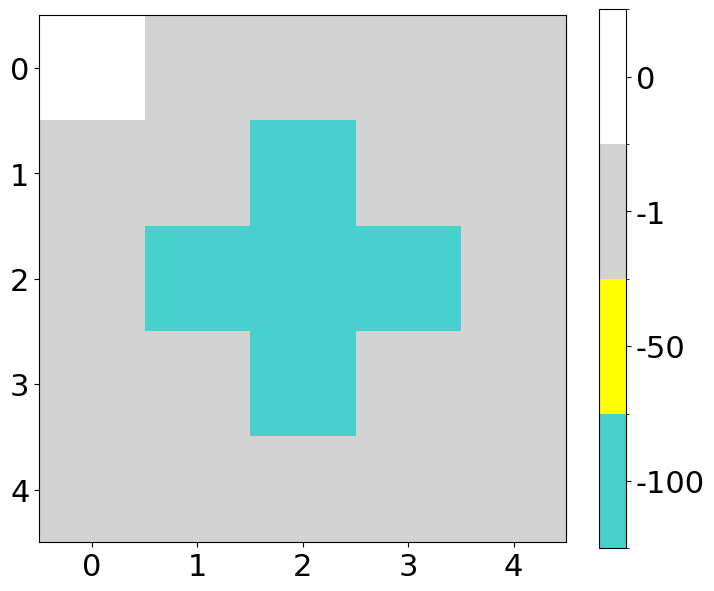

In [6]:
from gridworld import GridWorldEnvironment
import plot
import numpy as np
import cvxpy as cp

seed = 42
np.random.seed(seed)
#generate environment of type 2
env = GridWorldEnvironment(prop = 0.0, env_type = 2)
## plot the current environment
plot.plot_reward(env.w, 5, title="", tdw=False, show=True)

See below some example code on how to interact with the environment.

In [7]:
print("N states: ", env.n_states)
start_state_id=env.get_starting_index()
print("Starting state: ", start_state_id)
start_state = env.get_random_initial_index()
print("Starting state: ", start_state)
poss_actions = env.get_possible_actions(start_state)
print("Possible actions: ", poss_actions)
print("The possible actions are represented as follows: 0 is up, 1 is right, 2 is down, 3 is left")
#take action up
next_state_features, reward, terminal = env.step(0)
print("Next state features: ", next_state_features)
print("next state: ", env.get_current_state())
print("Reward: ", reward)
print("Terminal: ", terminal)
# take action left
next_state_features, reward, terminal = env.step(3)
print("Next state features: ", next_state_features)
print("next state: ", env.get_current_state())
print("Reward: ", reward)
print("Terminal: ", terminal)


N states:  25
Starting state:  19
Starting state:  23
Possible actions:  []
The possible actions are represented as follows: 0 is up, 1 is right, 2 is down, 3 is left
Next state features:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
next state:  [0 1]
Reward:  -1.0
Terminal:  False
Next state features:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
next state:  [0 0]
Reward:  0.0
Terminal:  True


Now we want to implement value iteration as an RL algorithm to use to generate the optimal policy.

## Exercise 2.1 (5pts) Train Expert Policy (Complete the code below)

In [8]:
class RL_algorithm:
    def __init__(self, env):
        self.env = env
        self.state_space = env.get_n_states()
        self.action_space = env.get_n_actions()
        self.values = np.zeros(self.state_space)
        self.q_values = np.zeros((self.state_space, self.action_space))
        self.policy = np.zeros(self.state_space, dtype=int)

    def value_iteration(self, max_iterations=100,tol=1e-9):
        discount_factor = self.env.get_discount_factor()
        #initialise new_values randomly between 0 and 1
        new_values = np.random.rand(self.state_space)
        for i in range(max_iterations):
            old_values = self.values.copy()
            for state in range(self.state_space):
                q_values = []
                for action in range(self.action_space):
                    #TODO students should implement the Q-value computation, 
                    # Hint use: state_step(self, state_index, a)
                    next_state, reward, done = self.env.state_step(state, action)
                    q_values.append(reward + discount_factor * self.values[next_state] * (not done))
                #TODO impplement the value update and policy update
                new_values[state] = np.max(q_values)
                self.policy[state] = np.argmax(q_values)
                
            self.values = new_values
            if np.max(np.abs(old_values - self.values)) < tol:
                break
                
        #calculate the q_values from the values
        self.q_values = np.zeros((self.state_space, self.action_space))
        for state in range(self.state_space):
            for action in range(self.action_space):
                next_state, reward, done = self.env.state_step(state, action)
                self.q_values[state, action] = reward + discount_factor * self.values[next_state] * (not done)
        return self.values, self.q_values, self.policy
    

If your code was correct, we should get a meaningful plot below of the value and policy function.

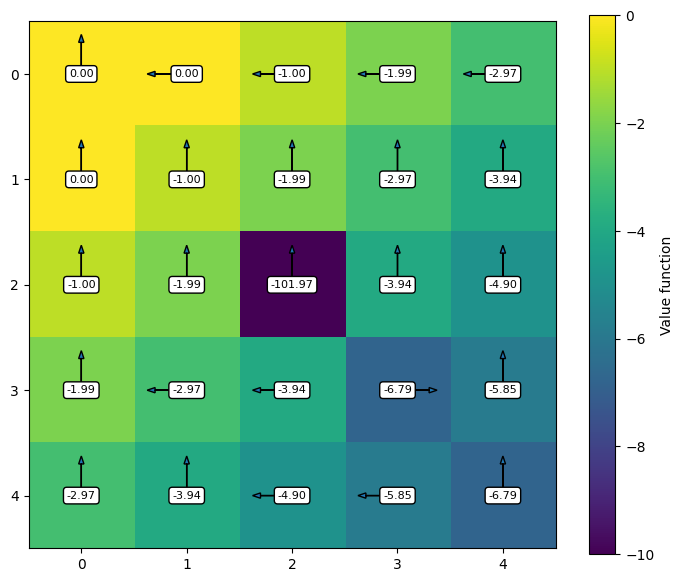

In [9]:
#Run the value iteration algorithm
rl = RL_algorithm(env)
values, q_values, expert_policy = rl.value_iteration()
#plot the values 
plot.plot_value_policy(values,expert_policy,5, title="Values", show=True)

Now that we have an optimal policy, we can try and recover the reward function from it using max-margin RL. For this we need to generate trajectories to calculate the feature expectation as follows :
$$\mu(\pi)=E\left[\sum_{t=0}^{\infty} \gamma^t \phi\left(s_t\right) \mid \pi\right].$$

In [10]:
#Generate| expert trajectory, using the optimal policy policy until the end of the episode
def generate_trajectory(env, policy, state = None, max_steps=100):
    done = False
    if state is None:
        state = env.get_random_initial_index()
    states = [state]
    actions = []
    step = 0
    while not done and step < max_steps:
        action = policy[state]
        next_state, reward, done = env.state_step(state, action)
        state = next_state
        states.append(state)
        actions.append(action)
        step += 1
    return states, actions
states, actions = generate_trajectory(env, expert_policy)

In [11]:
# generate the feature expectations using the expert trajectory,
# env.get_discount_factor and env.get_feature
def generate_feature_expectations(env, states, discount_factor):
    feature_expectations = np.zeros(env.get_features_dim())
    for i, state_id in enumerate(states):
        feature_expectations += discount_factor**i * env.get_features(state_id=state_id)
    return feature_expectations

def generate_MC_feature_expectations(env, policy, discount_factor, num_episodes=1000):
    feature_expectations = np.zeros(env.get_features_dim())
    for i in range(num_episodes):
        env.reset()
        states, actions = generate_trajectory(env, policy)
        feature_expectations += generate_feature_expectations(env, states, discount_factor)/num_episodes
    return feature_expectations

expert_features = generate_MC_feature_expectations(env, expert_policy, env.get_discount_factor(), num_episodes=10000)
print("Feature expectations: \n", expert_features)

Feature expectations: 
 [0.9979487  0.58105444 0.46667839 0.3511626  0.24039982 0.34918364
 0.077417   0.083058   0.075522   0.20161598 0.31341782 0.0383
 0.0442     0.0378     0.16213735 0.27708871 0.20142395 0.0389
 0.044      0.122765   0.0421     0.12203328 0.083872   0.0428
 0.0395    ]


## Exercise 2.2 (10pts) implement max margin IRL

In the following implement the max-margin IRL algorithm presented in the lecture (see also the following paper https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf for a detailed discussion and these slides from epfl for a concise explanation https://moodlearchive.epfl.ch/2020-2021/pluginfile.php/2744660/mod_resource/content/2/lecture%2012.pdf) For this you may use the following functions which solve the quadratic optimization problems:
$$\begin{array}{cl}\max _{t, w} & t \\ \text { s.t. } & w^T \mu_E \geq w^T \mu^{(j)}+t, j=0, \ldots, i-1 \\ & \|w\|_2 \leq 1\end{array}$$
and

$\min \left\|\mu_E-\mu\right\|_2$ s.t. $\mu=\sum_i \lambda_i \mu^{(i)}, \lambda_i \geq 0, \sum_i \lambda_i=1 $

You can reuse the value iteration above (the gridworld environment allows generating environments with "preset" w), or you can find the optimal policy in any way you like.



In [12]:
def optimize_w_t(mu_j, mu_E, i):
    """
    Optimize portfolio to maximize t.
    
    Parameters:
    - mu_j: A list or numpy array of expected returns for each asset (mu_j).
    - mu_E: The expected return of the portfolio (mu_E).
    - i: The number of assets.
    
    Returns:
    - The optimal value of t and the optimal weight vector w as a numpy array.
    """
    # Ensure mu_j is a numpy array
    mu_j = np.array(mu_j)

    # Define the optimization variables
    w = cp.Variable(len(mu_E))
    t = cp.Variable()

    # The objective is to maximize t
    objective = cp.Maximize(t)

    # Define the constraints
    constraints = [w.T @ mu_E >= w.T @ mu_j[j] + t for j in range(i)]
    constraints += [cp.norm(w, 2) <= 1]

    # Set up and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Extract the solution
    optimal_t = t.value
    optimal_w = w.value

    return optimal_t, optimal_w


def minimize_distance(target_mu, mus):
    """
    Minimize the Euclidean distance between a target mu and a combination of given mus.
    
    Parameters:
    - target_mu: The target expected return (mu_E).
    - mus: A list or 2D numpy array where each column represents an asset's expected return (mu^(i)).
    
    Returns:
    - The optimal weight vector lambda as a numpy array.
    """
    # Ensure mus is a numpy array
    mus = np.array(mus)
    i = mus.shape[0]  # Number of mus
    lambdas = cp.Variable(i)  # The weights we want to optimize

    # Objective: Minimize the 2-norm of the difference
    objective = cp.Minimize(cp.norm(target_mu - lambdas @ mus, 2))

    # Constraints: lambda_i >= 0 for all i, and sum(lambda_i) == 1
    constraints = [lambdas >= 0, cp.sum(lambdas) == 1]

    # Set up and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return lambdas.value


#### Exercise 2.2 (9 pts) Complete the code below:
Here you need to implement the max margin IRL aglorithm. Note you need to return the generated policy in a one-hot encoded format.

In [13]:
class MaxMarginIRL:
    def __init__(self, env, expert_features, epsilon=1e-4):
        self.env = env
        self.expert_features = expert_features
        self.epsilon = epsilon
        self.policies = [np.ones(shape=env.get_n_states(), dtype=int)]
        self.feature_expectations = [self.compute_feature_expectations(self.policies[0])]

    def compute_feature_expectations(self, policy):
        # compute the feature expectations using the trajectory
        feature_expectations = generate_MC_feature_expectations(env, policy, env.get_discount_factor(), num_episodes=600)
        return feature_expectations
    
    def run(self):
        """
        Runs the algorithm to compute the final policy.

        This function iteratively generates feature expectations until a certain threshold is reached.
        It optimizes the weights and computes the final policy based on the expert features and generated feature expectations.

        Returns:
        - w: The optimized weights. Shape (n_features,)
        - t: The final threshold value. Shape (1,)
        - final_policy: The computed final policy. Shape (n_states, n_actions)
        - policies: The list of policies generated during the iterations. Shape (n_policies, n_states)
        - feature_expectations: The list of feature expectations generated during the iterations. Shape (n_policies, n_features)
        """
        # generate feature expectations until t is small enough
        i = 1
        t = 0;
        while True and i < 100:
             
            print("current policy: ", self.policies[-1])
            print("Iteration: ", i, " t: ", t)
            # TODO implement this using optmize_w_t
            t, w = optimize_w_t(self.feature_expectations, self.expert_features, i)
            
            env = GridWorldEnvironment(w=w, prop=0.0, env_type=2)
            rl_algo = RL_algorithm(env)
            _, _, policy = rl_algo.value_iteration()
            current_policy = policy

            i += 1
            self.policies.append(current_policy)
            self.feature_expectations.append(self.compute_feature_expectations(current_policy))
            
            if t < self.epsilon:
                break


        
        lambdas = minimize_distance(self.expert_features, self.feature_expectations)
        # Compute the final policy pi=lambda1*pi1+...+lambda_k*pik
        # note that we need to translate the policies of shape (25,) to (25,4) using one-hot encoding 
        final_policy = np.zeros((self.env.get_n_states(), self.env.get_n_actions()))
        for i, policy in enumerate(self.policies):
            final_policy += lambdas[i] * np.eye(self.env.get_n_actions())[policy.astype(int)]
        #Compute the final feature expectations
        final_feature_expectations = np.zeros(self.env.get_features_dim())
        for i, feature_expectation in enumerate(self.feature_expectations):
            final_feature_expectations += lambdas[i] * feature_expectation        

        return w, t, final_policy, final_feature_expectations, self.policies, self.feature_expectations
    
max_margin_irl = MaxMarginIRL(env, expert_features)
w, t, final_policy, final_features, policies, feature_expectations = max_margin_irl.run()


current policy:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Iteration:  1  t:  0
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  2  t:  26.64694214932138
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  3  t:  0.03312650111944355
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  4  t:  0.028453991691917126
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  5  t:  0.028445347615606253
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  6  t:  0.027220347834799617
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  7  t:  0.02722034859327829
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  8  t:  0.01968773416790111
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 3 0]
Iteration:  9  t:  0.01822437100915823
current policy:  [0 3 3 3 3 0 0 0 0 0 0 0 0 0

Now we want to analyse the result. First we look at the difference of the feature expectation under the optimal policy and the we plot the policy and the corresponding reward function and compare to our initial initialisation.


Distance of feature expectations:  0.0020684428615824185


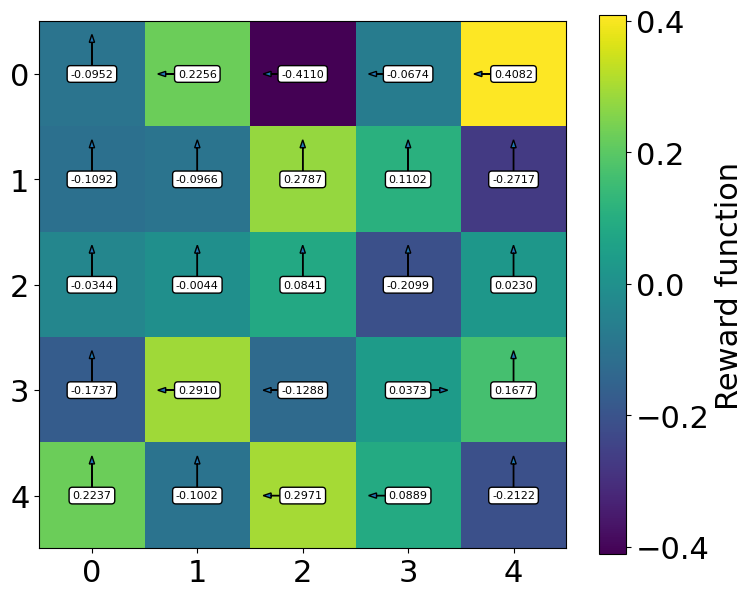

In [14]:
#Distance of feature expectation
print("Distance of feature expectations: ", np.linalg.norm(final_features - expert_features))
#turn the final policy into a deterministic policy
final_policy_det = np.argmax(final_policy, axis=1)
# Plot of policy and recovered rewards
plot.plot_reward_policy(w, final_policy_det, 5, title="Final deterministic policy", show=True)

#### Exercise 2.3 (1pt) 
Note that the feature expecations and recovered policy match quite closely. However, the rewards vary significantly and it might hard to see the original cross. Explain this behaviour.

<span style="color:lightblue"> Usually, the reward function is designed so that the learners behaviour matches the expert's behavior. But because there are only so many states and different rewards can create similar behaviors, the inferred reward might not be unique or exactly like the expert's original reward function. Also the problem is undetermined, as stated in the next section </span>

# Exercise 3. Maximum entropy IRL
In this exercise you work on max entropy inverse RL. The simple gridworld environment of the previous exercise is expected to be used.

<!-- ## For starters: some notation and theory -->

<!-- **The usual MDP**:

- states
    $S = {s_i}$
- actions $A = {a_i}$
- transition dynamics $T = p(s_{i+1}|s_t, a_t)$
- reward $R : S \rightarrow \mathbb{R}$

**Trajectories**:
- trajectory $\tau = \{ (s_0, a_0), (s_1, a_1) \dots (s_T, a_T)\}$
- demonstration $\mathcal{D} = \{ \tau_0, \tau_1, \dots \tau_{D} \}$

**Features**:
- $\Phi : S \rightarrow \mathbb{R}^d$ with $\Phi(\tau) = \Sigma_{s_i \in \tau}(s_i)$

**Policies**:
- stochastic policy $\pi(a_i | s_i)$
- learner policy $\pi^{L}$
- expert policy $\pi^{E}$, we assume that the expert policy is close-to-optimal
    $\pi^{E} \sim \pi^{\star}$
- learned reward $r_L(s, a)$, suppose also that such reward is parametrized by $\theta$
- learned reward trajectory-wise $R_L(\tau) = \Sigma_{t=0}^{T} r_{L}(s_t, a_t)$ -->

**Problem**

*Given*:
- state and action space
- roll-outs trajectories from $\pi^{E}$
- possibly the transition model

*Goal*:
- recover the reward function $R$
- then from the reward $R$, get the policy $\pi$

The agent is assumed to be attempting
to optimize some function that linearly maps the features
of each state, $f_{s_j} \in \mathbb{R}_f$,
to a state reward value representing the agent reward for visiting that state.
This function is parameterized by some reward weights, θ.

**Challenges**

- As seen in the previous exercise, the reward function which we recover is pretty different with respect to the one defined in the environment, this because the problem is undetermined
- It is difficult to evaluate a learned reward, it may mismatch the original one
- The demonstrations themselves may be sub-optimal

**Preliminary results**

The learner policy should visit, *in expectation*, the same features as the expert one.

*Feature Expectation Matching*

Reference [Abbel and Ng 2004](https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf)
This matching is both necessary and sufficient to achieve the same performance as the agent if the agent were in fact solving an MDP
with a reward function linear in those features.

$\mathbb{E}_{\pi^{E}} [\Phi(\tau)] = \mathbb{E}_{\pi^{L}} [\Phi(\tau)]$

We want to find the reward function $R : S -> \mathcal{R}$
defining

*Max entropy formulation*

$$p(\tau) = \dfrac{1}{Z} \exp{(R_{L}(\tau))}$$
where $R_{L}$ is the learned reward.
And the normalization is $Z = \int \text{exp}(R_{L}(\tau)) \text{d}\tau$.
Now
$$\text{max}_{R_{L}} \underbrace{\Sigma_{\tau \in \mathcal{D}} \text{log} p_{R_{L}} (\tau)}_{\mathcal{L}}$$

## Question 3.1 (1pt)
Compute the gradient update $\nabla_\theta R_L(\theta)$ of the learned reward $R_L(\theta)$,  which to maximize the entropy with respect to the collected demonstrations $\mathcal{D}$.

**Fill the proof here in latex format**


## Algorithm: Maximum entropy Inverse RL
From [Ziebart 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf)

*Setup*:
- Gather expert demostrations $\mathcal{D}$
- Initialize $\theta$ to some good guess

*Iteration*:
1. Solve for optimal policy $\pi_{L}(a|s)$ with reward $r_{L}(\theta)$
2. Solve for the transition dynamics $p(s|r_L(\theta))$
3. Compute the gradient $\nabla_{\theta} \mathcal{L}= -\dfrac{1}{|\mathcal{D}|}\Sigma_{\tau \in \mathcal{D}} \dfrac{\text{d}R_{L}(\tau)}{\text{d}\theta} - {\Sigma_s p(s | r_{L}(\theta)) \frac{\text{d}r_{L}(s)}{\text{d}\theta}}$
4. Update $\theta$ with one gradient step
5. Iterate to convergence

## Question 3.2 (1pt)
We use the same environment and expert policy as before.

[-100.5  -99.5  -49.5   -0.5    0.5]


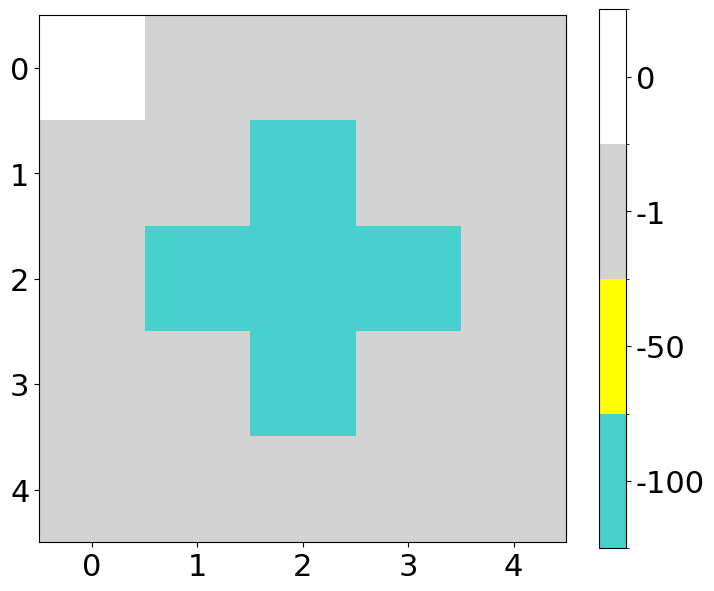

In [15]:
# plot the reward
plot.plot_reward(env.w, env.size, title="", tdw=False, show=True)

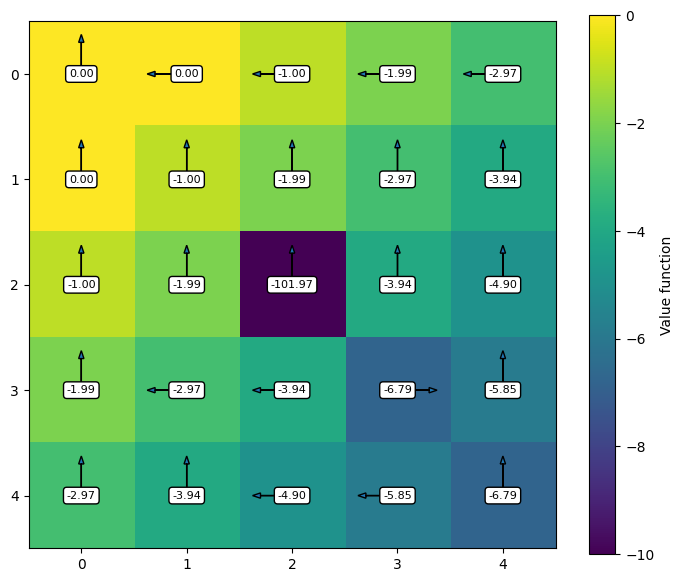

In [16]:
# plot the values 
plot.plot_value_policy(values, expert_policy, env.size, title="Values", show=True)

## Question 3.3 Generate Expert Demostrations (2pt)
Generate 5 **grid-states** trajectories of length at most 100 from the expert policy learned in the previous point

In [20]:
#Generate the expert trajectory, using the optimal policy policy until the end of the episode
def generate_random_demostrations(env, policy, n_trajectories, max_steps = 1000):
    states_trajectories = []
    actions_trajectories = []
    for _ in range(n_trajectories):
        # randomize the initial state convert to grid states
        states = []
        actions = []
        for _ in range (max_steps):
            done = False
            
            if len(states) == 0:
                states.append(env.get_starting_index())
                
            actions.append(policy[states[-1]])
            next_state, reward, done = env.state_step(states[-1], actions[-1])
            if done:
                break
            
            states.append(next_state)
            
        
        states_trajectories.append(states)
        actions_trajectories.append(actions)
        
    return states_trajectories, actions_trajectories

states_trajectories, actions_trajectories = generate_random_demostrations(env, expert_policy, 100)

# Print the demonstrations
print(states_trajectories)

[[4, 3, 2, 1], [11, 6, 1], [18, 19, 14, 9, 4, 3, 2, 1], [13, 8, 3, 2, 1], [2, 1], [4, 3, 2, 1], [19, 14, 9, 4, 3, 2, 1], [6, 1], [14, 9, 4, 3, 2, 1], [14, 9, 4, 3, 2, 1], [23, 22, 21, 16, 15, 10, 5], [8, 3, 2, 1], [21, 16, 15, 10, 5], [14, 9, 4, 3, 2, 1], [20, 15, 10, 5], [12, 7, 2, 1], [0], [20, 15, 10, 5], [2, 1], [2, 1], [11, 6, 1], [11, 6, 1], [12, 7, 2, 1], [0], [16, 15, 10, 5], [2, 1], [4, 3, 2, 1], [1], [2, 1], [10, 5], [3, 2, 1], [11, 6, 1], [22, 21, 16, 15, 10, 5], [4, 3, 2, 1], [21, 16, 15, 10, 5], [21, 16, 15, 10, 5], [9, 4, 3, 2, 1], [15, 10, 5], [1], [0], [10, 5], [2, 1], [12, 7, 2, 1], [15, 10, 5], [1], [10, 5], [13, 8, 3, 2, 1], [12, 7, 2, 1], [20, 15, 10, 5], [23, 22, 21, 16, 15, 10, 5], [18, 19, 14, 9, 4, 3, 2, 1], [13, 8, 3, 2, 1], [11, 6, 1], [21, 16, 15, 10, 5], [1], [21, 16, 15, 10, 5], [2, 1], [22, 21, 16, 15, 10, 5], [2, 1], [13, 8, 3, 2, 1], [18, 19, 14, 9, 4, 3, 2, 1], [16, 15, 10, 5], [1], [9, 4, 3, 2, 1], [1], [15, 10, 5], [13, 8, 3, 2, 1], [8, 3, 2, 1], [21,

## Question 3. Implement the algorithm (10pt)
Implement the missing functions in this class to calculate the gradient as in the referenced paper [Ziebart 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf).
Complete accordingly: `compute_feature_expectations`, `compute_intial_probabilities`, `compute_reward`, `backward_pass` and `forward_pass`
These functions will be called to compute the gradient in `compute_gradient` (which is provided, together the remaining functions). Be careful as you need to provide the correct outputs for the algorithm to correctly work.

In [53]:
class MaxEntropyIRL():
    def __init__(self, demonstrations, optimizer, environment, max_iter):
        self.states_trajectories = demonstrations
        self.optimizer = optimizer
        self.env = environment
        self.max_iter = max_iter
        self.terminal = self.env.terminal_indexes[0]
        self.n_features = self.env.features_dim
        self.n_actions = self.env.n_actions
        self.n_states = self.env.n_states
        self.p_transition = self.env.P

    @property
    def features(self):
        return self.env.features
    
    def compute_feature_expectations(self):
        # TODO Process from demonstrations trajectories, get the feature expectations
        
        e_features = np.zeros(self.n_features)
        for state_trajectory in self.states_trajectories:
            for state in state_trajectory:
                e_features += self.env.get_features(state_id=state)
            
        e_features /= len(self.states_trajectories)
        
        return e_features

    def compute_initial_probabilities(self):
        # TODO Implement
        p_initial = np.zeros(self.n_states)
        for t in self.states_trajectories:
            initial_state = t[0]
            p_initial[initial_state] += 1
        p_initial /= len(self.states_trajectories)
        return p_initial

    def compute_reward(self, theta):
        # TODO Compute state reward, as a scalar
        return np.multiply(theta, self.compute_feature_expectations())
    
    def backward_pass(self, reward, eps_esvf = 1e-3):
        # TODO complete the backward pass as described in the reference
        za = np.zeros((self.n_states, self.n_actions))
        zs = np.ones(self.n_states)
        P = self.p_transition
        zs_prev = zs
        i = 0
        while i < self.max_iter:
            for state in range(self.n_states):
                for action in self.env.get_possible_actions(state_id=state):
                    za[state][action] = np.sum([P[action][next_state][state] * np.exp(reward[state]) * zs[next_state] for next_state in range(self.n_states)])
            
            zs = np.array([np.sum([za[state][action] for action in self.env.get_possible_actions(state_id=state)]) for state in range(self.n_states)])
            if np.max(np.abs(zs - zs_prev)) < eps_esvf:
                break

            zs_prev = zs
            i += 1

        return za, zs

    def compute_local_action_probabilities(self, za, zs):
        # Compute local action probabilities
        p_action = za / zs[None, :]
        return p_action
        
    def forward_pass(self, p_action, eps_esvf = 1e-3):
        # TODO
        # compute the forward-pass
        # Hints set-up transition matrices for each action
        p_transition = self.env.get_transition_matrix()

        # actual forward-computation of state expectations
        d = self.compute_initial_probabilities()
        delta = np.inf
        while delta > eps_esvf:
            # TODO loop until the convergence criterion is met
            d_ = [np.sum([np.sum([d[k]*p_action[s_i]*p_transition[k][a_i_j][s_i] for k in range(self.n_states)]) for a_i_j in self.env.get_possible_actions(state_id=s_i)]) for s_i in range(self.n_states)]
            delta, d = np.max(np.abs(d_ - d)), d_
        return d
    
    def gradient_computation(self, theta):
        # This function recovers the gradient to use in optimization
        reward = self.compute_reward(theta)
        za, zs = self.backward_pass(reward)
        p_action = self.compute_local_action_probabilities(za, zs)
        e_svf = self.forward_pass(p_action)
        gradient = self.e_features - self.features.T.dot(e_svf)
        return gradient
    
    def run(self, initial_guess, eps = 1e-4):
        # Gradient ascent optimization
        self.theta = theta = initial_guess(self.n_features)
        self.optimizer.init(theta)

        # Compute static properties from demonstrations
        self.e_features = self.compute_feature_expectations()
        self.p_initial = self.compute_initial_probabilities()

        delta = np.inf
        counter = 0
        
        while delta > eps and counter < self.max_iter:
            theta_old = theta.copy()
            gradient = self.gradient_computation(theta)

            self.optimizer.step(gradient)
            delta = np.max(np.abs(theta_old - self.theta))
            if counter % 100 == 0 or delta < eps:
                print("Iteration : ", counter, "Tolerance : ", delta)
            counter += 1

        return self.compute_reward(theta)

## Question 3.3 Run the Max Entropy IRL (1pt)
Run the algorithm on the state trajectories generated as demostrations and plot and comment the result.
Select a proper initial guess for the algorithm.

In [54]:
from optimization import ExponentiatedSGA, Constant, linear_decay
optimizer = ExponentiatedSGA(lr = linear_decay(lr0 = 0.2))
max_iter = 1e3
tolerance = 1e-5
# TODO select a good initial guess (picking an initial_state) for the optimization loop
initial_state = 0 # TODO
initial_guess = Constant(initial_state)
solver = MaxEntropyIRL(states_trajectories, optimizer, env, max_iter)
reward = solver.run(initial_guess, tolerance)

[2. 1. 2. 2. 0. 1. 4. 4. 4. 2. 2. 4. 4. 4. 2. 2. 4. 4. 4. 2. 0. 2. 2. 2.
 0.]
[ 4.  2.  3.  2.  0.  2. 10. 14. 12.  2.  3. 14. 16. 14.  4.  2. 12. 14.
 12.  2.  0.  2.  4.  2.  0.]
[ 8.  3.  4.  3.  0.  3. 32. 41. 32.  4.  4. 41. 56. 44.  4.  3. 32. 44.
 32.  4.  0.  4.  4.  4.  0.]
[ 16.   4.   6.   4.   0.   4.  88. 124.  92.   4.   6. 124. 170. 124.
   8.   4.  92. 124.  96.   4.   0.   4.   8.   4.   0.]
[ 32.   6.   8.   6.   0.   6. 256. 356. 256.   8.   8. 356. 496. 366.
   8.   6. 256. 366. 256.   8.   0.   8.   8.   8.   0.]
[  64.    8.   12.    8.    0.    8.  724. 1016.  736.    8.   12. 1016.
 1444. 1016.   16.    8.  736. 1016.  748.    8.    0.    8.   16.    8.
    0.]
[ 128.   12.   16.   12.    0.   12. 2048. 2916. 2048.   16.   16. 2916.
 4064. 2944.   16.   12. 2048. 2944. 2048.   16.    0.   16.   16.   16.
    0.]
[  256.    16.    24.    16.     0.    16.  5856.  8176.  5888.    16.
    24.  8176. 11720.  8176.    32.    16.  5888.  8176.  5920.    16.
     0.   

/Users/dcsteinhauser/anaconda3/envs/forl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/7k/l2232z_97bqdhyy57gds7zqh0000gn/T/ipykernel_96589/3450855120.py:52: RuntimeWarning: invalid value encountered in scalar multiply
  za[state][action] = np.sum([P[action][next_state][state] * np.exp(reward[state]) * zs[next_state] for next_state in range(self.n_states)])


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan


ValueError: operands could not be broadcast together with shapes (25,4) (1,25) 

In [ ]:
import matplotlib.pyplot as plt
plot.plot_reward_policy(reward, expert_policy, env.size, title="Final deterministic policy", show=True)

Compare this with the plot of the max margin IRL. What do you notice about the recovered rewards?